In [1]:
import robin_stocks.robinhood as rh
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib as plt
import matplotlib.dates as mdates
import datetime as dt
from scipy.signal import argrelextrema as aex

# Stock Data Class

In [2]:
#Input Information - replace with personal robinhood login data and analysis selection
user = '' #Robinhood Login
key = '' #Robinhood password
ticker = 'TSLA' #Stock ticker symbol
interval = 'day' #Frequency of data
span = 'year' #Analysis duration

In [3]:
class Stocky:
    
    results = {'Date': [], 'High': [], 'Low': [], 'Open': [], 'Close': [], 'Volume': []}
    
    def __init__(self, symbol, user, key):
        self.symbol = symbol
        self.user = user
        self.key = key
    
    def login(self):
        #Logins to robin stock api using credentials above.
        rh.login(username = self.user, password = self.key, expiresIn = 86400, by_sms = True)
        
    def logout(self):
        rh.logout()
    #Returns historical data
    def get_historical(self, symbol, intervalArg, spanArg, boundsArg = 'regular'):
        '''Dictionary keys for optional 'info' parameter:
        begins_at, open_price, close_price, high_price, low_price, volume, session, interpolated, symbol
        '''
        data = rh.get_stock_historicals(symbol,interval=intervalArg,span=spanArg,bounds=boundsArg)
        return data
    
    def latest_price(self, symbol, price_type, extended_hours = True):
        '''symbol takes a stock ticker or a list of multiple tickers
        price_type takes one string, 'ask_price' or 'bid_price'
        extended_hours takes one bool, True to include extended hours if avaliable
        '''
        price = rh.get_latest_price(symbol, price_type, extended_hours)
        price = round(float(price[0]), 2)
        today = dt.date.today()
        return 'The latest price for {} on {} is ${}.'.format(symbol, today, round(price, 2))
    
    def get_details(self, symbol):
        #Returns fundamental stock information for input ticker symbol
        details = rh.get_fundamentals(symbol)
        return details
    
    def get_ratings(self, symbol):
        #Returns buy, sell, hold ratings for input ticker symbol
        ratings = rh.get_ratings(symbol)
        if ratings['summary'] is None:
            return 'No ratings avaliable for {} at this time.'.format(symbol)
        return ratings
    
    def clean_data(self, data):
        for item in data:
            date = item['begins_at'][:10]
            date = dt.datetime.strptime(date, '%Y-%m-%d')
            self.results['Date'].append(date)
            self.results['High'].append(round(float(item['high_price']), 2))
            self.results['Low'].append(round(float(item['low_price']), 2))
            self.results['Open'].append(round(float(item['open_price']), 2))
            self.results['Close'].append(round(float(item['close_price']), 2))
            self.results['Volume'].append(item['volume'])
                
    def get_min_max(self, data, win_range):
        data['max'] = data.iloc[aex(data['Close'].values, np.greater_equal, order = win_range)[0]]['Close']
        data['min'] = data.iloc[aex(data['Close'].values, np.less_equal, order = win_range)[0]]['Close']
          
if __name__ == '__main__':
    ro = Stocky(ticker, user, key)
    ro.login()
    latest_ask = ro.latest_price(ro.symbol, 'ask_price')
    historical_data = ro.get_historical(ro.symbol, interval, span)
    ro_details = ro.get_details(ro.symbol)
    ro_ratings = ro.get_ratings(ro.symbol)
    
    clean_data = ro.clean_data(historical_data)

# Look at results

In [4]:
#Prints latest asking price for stock
print(latest_ask)

The latest price for TSLA on 2021-04-17 is $748.0.


In [5]:
#Test print historic stock data
print(historical_data[0])

{'begins_at': '2020-04-17T00:00:00Z', 'open_price': '154.456000', 'close_price': '150.778000', 'high_price': '154.990000', 'low_price': '149.532000', 'volume': 65641185, 'session': 'reg', 'interpolated': False, 'symbol': 'TSLA'}


In [6]:
#Print stock fundamental details
print(ro_details)

[{'open': '729.330000', 'high': '749.408000', 'low': '724.600000', 'volume': '27979526.000000', 'market_date': '2021-04-16', 'average_volume_2_weeks': '32027147.000000', 'average_volume': '32027147.000000', 'high_52_weeks': '900.400000', 'dividend_yield': None, 'float': '771667904.322000', 'low_52_weeks': '134.758000', 'market_cap': '732636558823.234009', 'pb_ratio': '31.914300', 'pe_ratio': '1159.710000', 'shares_outstanding': '990343830.359342', 'description': 'Tesla, Inc. engages in the design, development, manufacture, and sale of fully electric vehicles, energy generation and storage systems. It also provides vehicle service centers, supercharger station, and self-driving capability. The company operates through the following segments: Automotive and Energy Generation and Storage. The Automotive segment includes the design, development, manufacture and sale of electric vehicles. The Energy Generation and Storage segment includes the design, manufacture, installation, sale, and lea

In [7]:
#Print stock rating information
print(ro_ratings)

{'summary': {'num_buy_ratings': 10, 'num_hold_ratings': 15, 'num_sell_ratings': 9}, 'ratings': [{'published_at': '2021-04-03T00:36:36Z', 'type': 'buy', 'text': b'Tesla has the potential to change the world with long-range EV technology, AV technology, and battery technology that can store solar energy that its products generate.'}, {'published_at': '2021-04-03T00:36:36Z', 'type': 'buy', 'text': b'The cost advantage of recharging over gasoline is significant, and gas will probably never be able to catch up. Furthermore, the instant torque of EVs makes them fun to drive, as the vehicle is always at full power.'}, {'published_at': '2021-04-03T00:36:36Z', 'type': 'buy', 'text': b'Its unique Supercharger network makes Tesla the only automaker directly trying to alleviate the range anxiety of buying an EV.'}, {'published_at': '2021-04-03T00:36:36Z', 'type': 'sell', 'text': b'Investing in Tesla carries tremendous uncertainty. The market has high expectations for the stock, so a slowdown in gr

# Convert to Pandas dataframe from dictionary

In [8]:
#Test print results dictionary
print(ro.results)

{'Date': [datetime.datetime(2020, 4, 17, 0, 0), datetime.datetime(2020, 4, 20, 0, 0), datetime.datetime(2020, 4, 21, 0, 0), datetime.datetime(2020, 4, 22, 0, 0), datetime.datetime(2020, 4, 23, 0, 0), datetime.datetime(2020, 4, 24, 0, 0), datetime.datetime(2020, 4, 27, 0, 0), datetime.datetime(2020, 4, 28, 0, 0), datetime.datetime(2020, 4, 29, 0, 0), datetime.datetime(2020, 4, 30, 0, 0), datetime.datetime(2020, 5, 1, 0, 0), datetime.datetime(2020, 5, 4, 0, 0), datetime.datetime(2020, 5, 5, 0, 0), datetime.datetime(2020, 5, 6, 0, 0), datetime.datetime(2020, 5, 7, 0, 0), datetime.datetime(2020, 5, 8, 0, 0), datetime.datetime(2020, 5, 11, 0, 0), datetime.datetime(2020, 5, 12, 0, 0), datetime.datetime(2020, 5, 13, 0, 0), datetime.datetime(2020, 5, 14, 0, 0), datetime.datetime(2020, 5, 15, 0, 0), datetime.datetime(2020, 5, 18, 0, 0), datetime.datetime(2020, 5, 19, 0, 0), datetime.datetime(2020, 5, 20, 0, 0), datetime.datetime(2020, 5, 21, 0, 0), datetime.datetime(2020, 5, 22, 0, 0), datetime

In [9]:
#Create dataframe from dictionary
df = pd.DataFrame.from_dict(ro.results)
print(df.head())

        Date    High     Low    Open   Close     Volume
0 2020-04-17  154.99  149.53  154.46  150.78   65641185
1 2020-04-20  153.11  142.44  146.54  149.27   73732885
2 2020-04-21  150.67  134.76  146.02  137.34  101045465
3 2020-04-22  146.80  137.74  140.80  146.42   71124155
4 2020-04-23  146.80  140.63  145.52  141.13   66183485


In [10]:
#Check for missing data
print(df.isnull().sum())

Date      0
High      0
Low       0
Open      0
Close     0
Volume    0
dtype: int64


# Analysis

In [11]:
#Check for correlation
data_corr = df.corr(method='pearson')
data_corr

,High,Low,Open,Close,Volume
High,1.000000,0.997024,0.997653,0.997875,-0.430438
Low,0.997024,1.000000,0.998208,0.998160,-0.464947
Open,0.997653,0.998208,1.000000,0.996563,-0.445757
Close,0.997875,0.998160,0.996563,1.000000,-0.440843
Volume,-0.430438,-0.464947,-0.445757,-0.440843,1.000000


<AxesSubplot:>

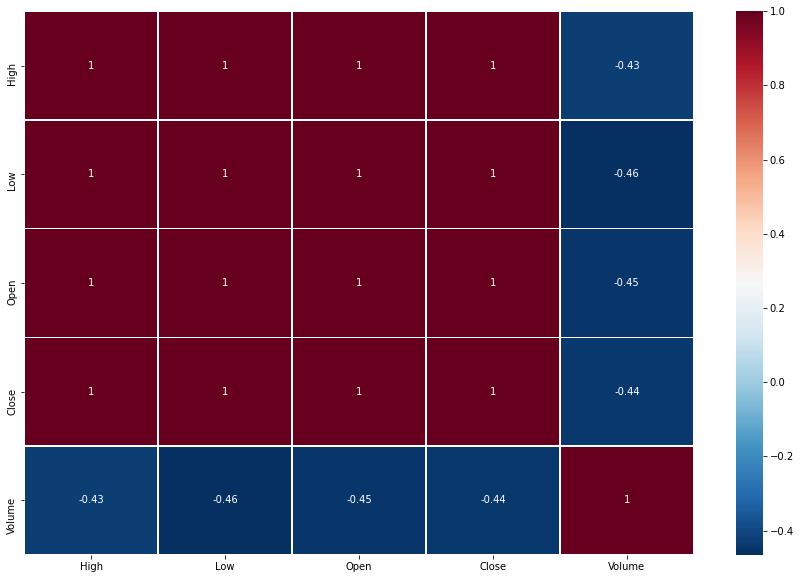

In [12]:
#Visualize corelation
f, ax = plt.pyplot.subplots(figsize=(15, 10))
sb.heatmap(data_corr,xticklabels=data_corr.columns, yticklabels=data_corr.columns,
 cmap='RdBu_r', annot=True, linewidth=0.5)

Text(0.5, 1.0, 'TSLA Closing Price over last year')

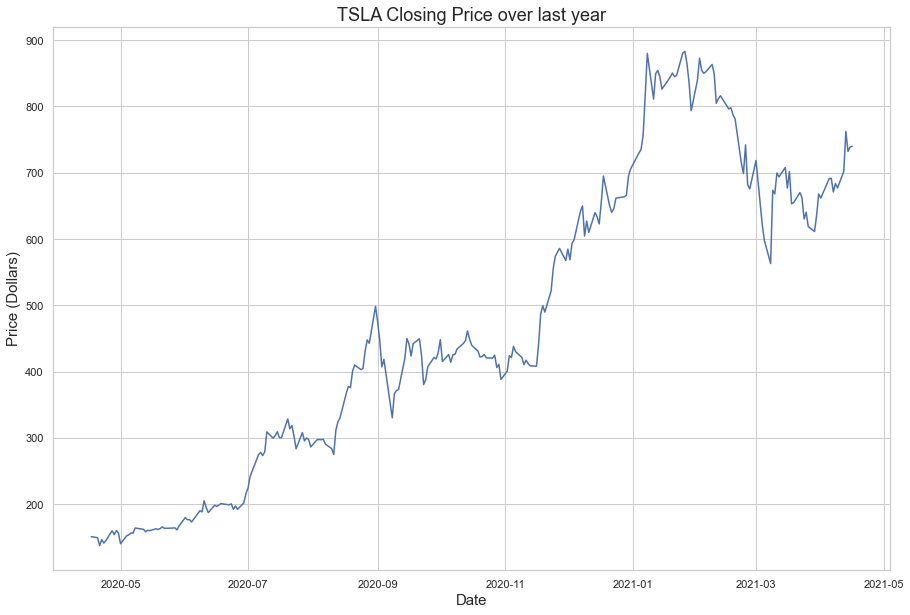

In [23]:
#Plot Stock closing price
sb.set_theme(style='whitegrid')
f, ax = plt.pyplot.subplots(figsize=(15, 10))
sb.lineplot(x = 'Date', y = 'Close',
           palette = 'Blues_d',
           data = df)
ax.set_xlabel('Date', fontsize = 15)
ax.set_ylabel('Price (Dollars)', fontsize = 15)
ax.set_title('{} Closing Price over last {}'.format(ticker, span), fontsize = 18)

Text(0.5, 1.0, 'TSLA Max/Min over last year')

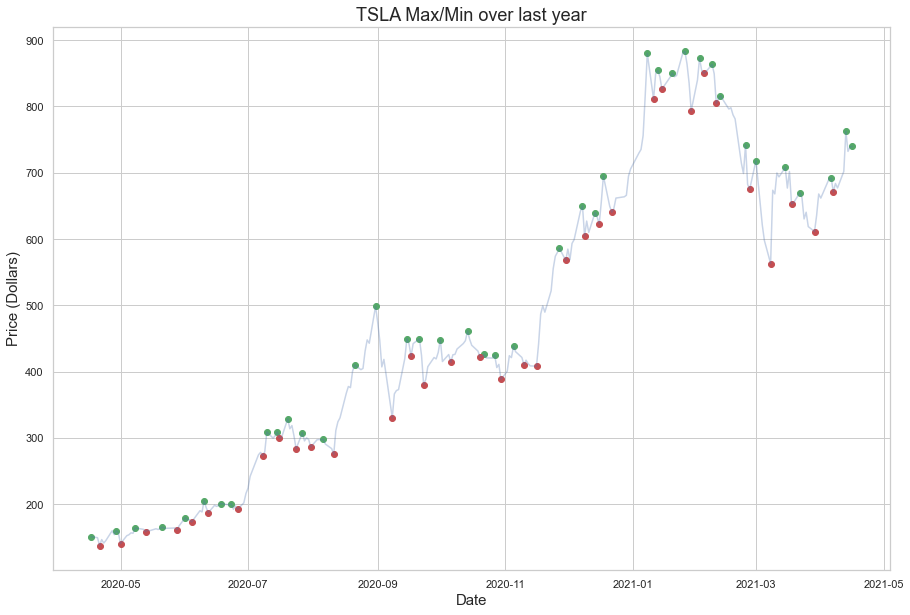

In [20]:
#Find min/max
ro.get_min_max(df, 2) #Dataframe input, window range, e.g. entering 3 would check for min/max for every 3 data points

sb.set_theme(style='whitegrid')
f, ax = plt.pyplot.subplots(figsize=(15, 10))
plt.pyplot.scatter(x = df['Date'], y = df['max'], c='g')
plt.pyplot.scatter(x = df['Date'], y = df['min'], c='r')
sb.lineplot(x = 'Date', y = 'Close',
           palette = 'Blues_d',
           data = df, alpha = 0.3)
ax.set_xlabel('Date', fontsize = 15)
ax.set_ylabel('Price (Dollars)', fontsize = 15)
ax.set_title('{} Max/Min over last {}'.format(ticker, span), fontsize = 18)

Text(0.5, 1.0, 'TSLA Max/Min Trends')

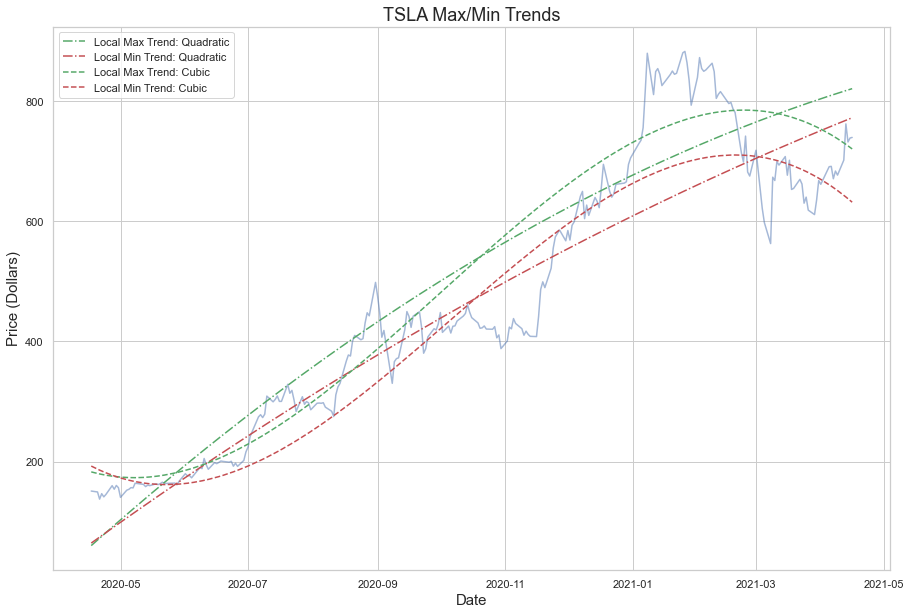

In [24]:
#print(df['max'], df['min'])
x_max = mdates.date2num(df['Date'])
y_max = df['max']
idx = np.isfinite(x_max) & np.isfinite(y_max)
#print(x_max, y_max)
max_fit_n1 = np.polyfit(x_max[idx], y_max[idx],1)
max_fit_n1_line = np.poly1d(max_fit_n1)
max_fit_n2 = np.polyfit(x_max[idx], y_max[idx],2)
max_fit_n2_line = np.poly1d(max_fit_n2)
max_fit_n3 = np.polyfit(x_max[idx], y_max[idx],3)
max_fit_n3_line = np.poly1d(max_fit_n3)
#print(max_fit)

x_min = mdates.date2num(df['Date'])
y_min = df['min']
idx = np.isfinite(x_min) & np.isfinite(y_min)
#print(x_min, y_min)
min_fit_n1 = np.polyfit(x_min[idx], y_min[idx],1)
min_fit_n1_line = np.poly1d(min_fit_n1)
min_fit_n2 = np.polyfit(x_min[idx], y_min[idx],2)
min_fit_n2_line = np.poly1d(min_fit_n2)
min_fit_n3 = np.polyfit(x_min[idx], y_min[idx],3)
min_fit_n3_line = np.poly1d(min_fit_n3)
#print(min_fit)

sb.set_theme(style='whitegrid')
f, ax = plt.pyplot.subplots(figsize=(15, 10))
sb.lineplot(x = 'Date', y = 'Close',
           palette = 'Blues_d',
           data = df, alpha = .5)

#plt.pyplot.scatter(x_max, y_max, c='g', alpha = 0.5)
#plt.pyplot.scatter(x_min, y_min, c='r', alpha = 0.5)
#plt.pyplot.plot(x_max, max_fit_n1_line(x_max), label = "Local Max Trend: Linear", linestyle = ':', c='g')
#plt.pyplot.plot(x_min, min_fit_n1_line(x_min), label = "Local Min Trend: Linear", linestyle = ':', c='r')
plt.pyplot.plot(x_max, max_fit_n2_line(x_max), label = "Local Max Trend: Quadratic", linestyle = '-.', c='g')
plt.pyplot.plot(x_min, min_fit_n2_line(x_min), label = "Local Min Trend: Quadratic", linestyle = '-.', c='r')
plt.pyplot.plot(x_max, max_fit_n3_line(x_max), label = "Local Max Trend: Cubic", linestyle = '--', c='g')
plt.pyplot.plot(x_min, min_fit_n3_line(x_min), label = "Local Min Trend: Cubic", linestyle = '--', c='r')

plt.pyplot.legend()
ax.set_xlabel('Date', fontsize = 15)
ax.set_ylabel('Price (Dollars)', fontsize = 15)
ax.set_title('{} Max/Min Trends'.format(ticker), fontsize = 18)

# Logout

In [16]:
#Logout
ro.logout()